In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from SALib.sample import saltelli
from SALib.analyze import sobol
from sklearn.linear_model import LinearRegression

### 1. Calculate Annuities and Insurance Premiums

Life insurance for people aged 18-59, assured amount is £500,000, insurance lasts for 5 years.

In [2]:
# Example life table for ages 18-59
life_table = pd.DataFrame({
    'age': np.arange(18, 60),
    'qx': np.random.uniform(0.001, 0.02, 42),  # Mortality rates between 0.1% and 2%
    'lx': np.random.randint(10000, 50000, 42)   # Survivors at the start of each age group
})
life_table

,age,qx,lx
0,18,0.008693,49239
1,19,0.007866,42508
2,20,0.011643,34330
3,21,0.012078,24590
4,22,0.002381,47510
5,23,0.014277,49569
6,24,0.014584,33156
7,25,0.015213,14831
8,26,0.011825,39996
9,27,0.011268,21006


In [3]:
# Policy parameters
death_benefit = 500000  # £500,000 policy
interest_rate = 0.03    # 3% interest rate (annual)  可以改
error_margin = 0.05     # 5% error margin for sensitivity analysis 可以改
year = 5                 # number of years of coverage

def calculate_premium(life_table, interest_rate, death_benefit, year):
    # Calculate present value of death benefit at each age
    life_table['premium'] = 0.0
    for idx, row in life_table.iterrows():
        age = row['age']
        qx = row['qx']
        
        # Calculate the discount factor for the age (assuming annual discount)
        discount_factor = 1 / (1 + interest_rate) ** (age - 18)  # Assume 18 is the starting age
        
        # Calculate the expected death benefit discounted
        life_table.loc[idx, 'premium']  = death_benefit * qx * discount_factor/year #present_value_death_benefit
    
    return life_table['premium'].mean()

premium = calculate_premium(life_table, interest_rate, death_benefit, year)
print(f"Calculated Avearge Annual Premium: £{premium:,.2f}")
life_table


Calculated Avearge Annual Premium: £631.45


,age,qx,lx,premium
0,18,0.008693,49239,869.305914
1,19,0.007866,42508,763.658973
2,20,0.011643,34330,1097.463641
3,21,0.012078,24590,1105.275096
4,22,0.002381,47510,211.553592
5,23,0.014277,49569,1231.577405
6,24,0.014584,33156,1221.384402
7,25,0.015213,14831,1236.992761
8,26,0.011825,39996,933.441569
9,27,0.011268,21006,863.628643


### 2. Analyse the risks for insurance policies above

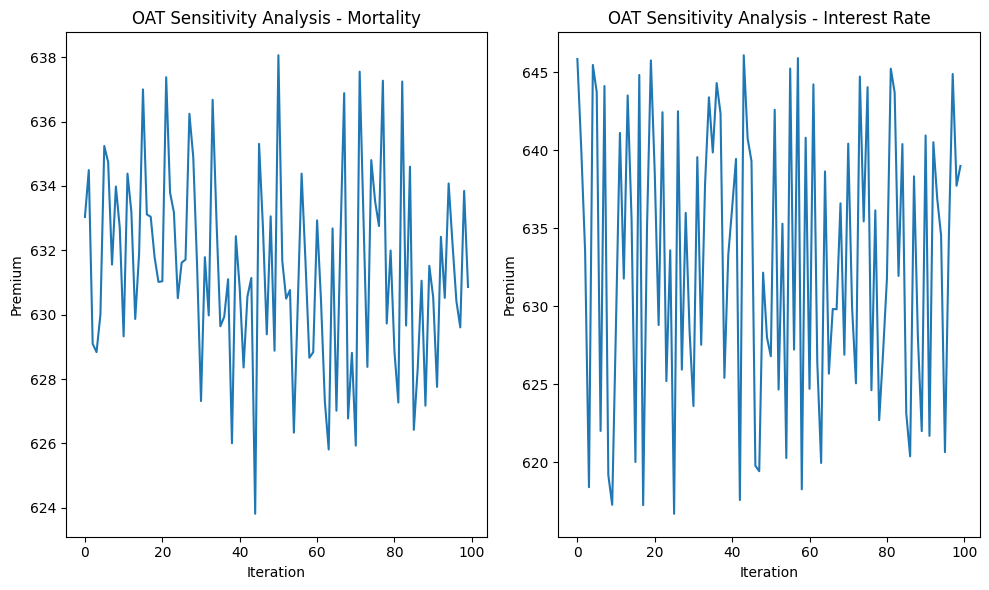

baseline premium: 631.4503488779567
Standard deviation for varying death probability: 2.9984673005418268
Standard deviation for varying interest rate: 8.96724927430693


In [5]:
# OAT Sensitivity Analysis
def oat_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin, year):
    # Perturb the mortality rate and interest rate one at a time
    premium_baseline = calculate_premium(life_table, interest_rate, death_benefit, year)
    premiums_mortality = []
    premiums_interest = []
    
    # Vary mortality rate
    for i in range(100):
        adjusted_life_table = life_table.copy()
        mortality_rate_change = np.random.uniform(-error_margin, error_margin, len(adjusted_life_table))
        adjusted_life_table['qx'] *= (1 + mortality_rate_change)
        premiums_mortality.append(calculate_premium(adjusted_life_table, interest_rate, death_benefit, year))
    
    # Vary interest rate
    for i in range(100):
        adjusted_interest_rate = interest_rate * (1 + np.random.uniform(-error_margin, error_margin))
        premiums_interest.append(calculate_premium(life_table, adjusted_interest_rate, death_benefit, year))
    
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(premiums_mortality)
    plt.title("OAT Sensitivity Analysis - Mortality")
    plt.xlabel("Iteration")
    plt.ylabel("Premium")
    
    plt.subplot(1, 2, 2)
    plt.plot(premiums_interest)
    plt.title("OAT Sensitivity Analysis - Interest Rate")
    plt.xlabel("Iteration")
    plt.ylabel("Premium")
    
    plt.tight_layout()
    plt.show()
    
    print("baseline premium:", premium_baseline)
    print("Standard deviation for varying death probability:", np.std(premiums_mortality))
    print("Standard deviation for varying interest rate:", np.std(premiums_interest))

oat_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin, year)

The premium value is more sensitive to a percentage change in interest rate than that in mortality rate.

In [10]:
# Sobol Indices Sensitivity Analysis
def sobol_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin, year):
    # Define the problem: change in mortality rates (qx) and interest rate (r)
    problem = {
        'num_vars': 2,
        'names': ['mortality_rate', 'interest_rate'],
        'bounds': [[-error_margin, error_margin], [-error_margin, error_margin]]
    }
    
    # Define input sample space
    param_values = saltelli.sample(problem, 1000, calc_second_order=True)
    
    # Perform Sobol sensitivity analysis
    Y = []
    for params in param_values:
        mortality_rate_change, interest_rate_change = params
        # Adjust life table mortality rates based on sensitivity factor
        adjusted_life_table = life_table.copy()
        adjusted_life_table['qx'] *= (1 + mortality_rate_change)
        
        # Adjust interest rate
        adjusted_interest_rate = interest_rate * (1 + interest_rate_change)
        
        # Recalculate premium with adjusted parameters
        premium = calculate_premium(adjusted_life_table, adjusted_interest_rate, death_benefit, year)
        Y.append(premium)
    
    Y = np.array(Y)
    Si = sobol.analyze(problem, Y)
    return Si

sobol_result = sobol_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin, year)
print("First Order Indices:", sobol_result['S1'])
print("Total Order Indices:", sobol_result['ST'])



C:\Users\xiang\AppData\Local\Temp\ipykernel_38100\2899363198.py:11: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 1000, calc_second_order=True)
C:\Users\xiang\AppData\Roaming\Python\Python312\site-packages\SALib\sample\saltelli.py:110: UserWarning: 
        Convergence properties of the Sobol' sequence is only valid if
        `N` (1000) is equal to `2^n`.
        
  warnings.warn(msg)


First Order Indices: [0.8150582  0.18678591]
Total Order Indices: [0.81275534 0.18527004]


C:\Users\xiang\AppData\Roaming\Python\Python312\site-packages\SALib\util\__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))


The interaction between mortality and interest rate is minimal. 两个自变量之间互相影响很小

In [11]:
# Regression-based Sensitivity Analysis
def regression_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin, year):
    # Create input variables (mortality rates and interest rates)
    mortality_rates = life_table['qx'].values
    interest_rates = np.full_like(mortality_rates, interest_rate)
    
    # Generate data by perturbing mortality rates and interest rate
    mortality_rate_change = np.random.uniform(-error_margin, error_margin, len(mortality_rates))
    interest_rate_change = np.random.uniform(-error_margin, error_margin, len(mortality_rates))
    
    X = np.vstack([mortality_rate_change, interest_rate_change]).T
    Y = []
    
    for i in range(len(mortality_rates)):
        # Adjust the life table and interest rate
        adjusted_life_table = life_table.copy()
        adjusted_life_table['qx'] *= (1 + mortality_rate_change[i])
        
        adjusted_interest_rate = interest_rate * (1 + interest_rate_change[i])
        
        # Calculate premium
        premium = calculate_premium(adjusted_life_table, adjusted_interest_rate, death_benefit, year)
        Y.append(premium)
    
    Y = np.array(Y)
    
    # Perform regression to analyze the sensitivity
    model = LinearRegression()
    model.fit(X, Y)
    
    sensitivity = model.coef_
    return sensitivity

regression_sensitivity = regression_sensitivity_analysis(life_table, interest_rate, death_benefit, error_margin, year)
print(f"Regression-based Sensitivity Analysis Coefficients: {regression_sensitivity}")



Regression-based Sensitivity Analysis Coefficients: [ 631.12010078 -304.82227449]


The regression line suggests the most probable linear relationship between the premium and [mortality, interest rate] is：

Premium = [631  ,  -304] $ \begin{bmatrix} p \\ r \end{bmatrix} $ = 631p - 304r